<a href="https://colab.research.google.com/github/Sharma-Kamlesh/EVA5-Phase1/blob/main/S5%20Assignment/S5_Code_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            
        ) # output_size = 22

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)    
            
        ) 
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

         # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            
        ) # output_size = 9
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)         
            
        ) 
        #self.pool2 = nn.MaxPool2d(2, 2)# output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock9 = nn.Sequential(
           nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
           nn.ReLU(),
           nn.BatchNorm2d(10),
           nn.AvgPool2d(3)
            # nn.ReLU() NEVER!
          ) # output_size = 1 
        self.convblock10 = nn.Sequential(
           nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
           #nn.AvgPool2d(3)
            # nn.ReLU() NEVER!
          ) # output_size = 1
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 10, 28, 28]             900
              ReLU-5           [-1, 10, 28, 28]               0
       BatchNorm2d-6           [-1, 10, 28, 28]              20
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             900
              ReLU-9           [-1, 10, 14, 14]               0
      BatchNorm2d-10           [-1, 10, 14, 14]              20
           Conv2d-11           [-1, 10, 14, 14]             100
             ReLU-12           [-1, 10, 14, 14]               0
      BatchNorm2d-13           [-1, 10, 14, 14]              20
           Conv2d-14           [-1

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09574142843484879 Batch_id=468 Accuracy=90.87: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Loss=0.1926826387643814 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.04108389467000961 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.05341571196913719 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.04355435445904732 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.022765303030610085 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.038181859999895096 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.05885230377316475 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.043889474123716354 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.005414388608187437 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.023305900394916534 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.02506924979388714 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.00503486068919301 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.013247613795101643 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.04273587465286255 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

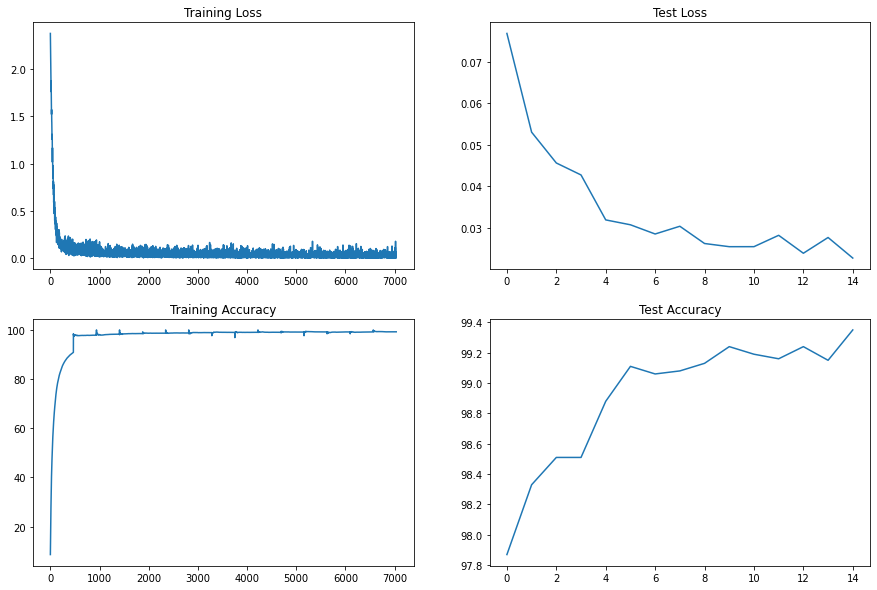

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")